# Episode 27. Causality (2): Synthetic Control

Comments:
The code below is an adaptation (with minor modification) from **Causal Inference for The Brave and True**

https://matheusfacure.github.io/python-causality-handbook/15-Synthetic-Control.html

The original code has more detailed explanations, which I highly encourage to visit the website and read.

## Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

%matplotlib inline

pd.set_option("display.max_columns", 6)
style.use("fivethirtyeight")

## Load Data

In [2]:
# https://matheusfacure.github.io/python-causality-handbook/15-Synthetic-Control.html
# comment:
# The original datafile from the above website is "smoking_data.csv," which has seven columns
# (state, year, cigsale, lnincome, beer, age15to24, retprice)."
# Two columns have been added: california, after_treatment
# "california" variableb is TRUE is state=3, and FALSE otherwise
# "after_treatment" is TRUE if year>1988 and FALSE otherwise.
# I renamed the file as "smoking.csv"
#
from google.colab import files
uploaded = files.upload()

Saving smoking.csv to smoking (6).csv


In [3]:
# read in pandas dataframe
cigar = (pd.read_csv("smoking.csv").drop(columns=["lnincome","beer", "age15to24"]))

In [4]:
# check data
cigar.query("california").head()

,state,year,cigsale,retprice,california,after_treatment
17,3,1970,123.000000,38.799999,True,False
68,3,1971,121.000000,39.700001,True,False
96,3,1972,123.500000,39.900002,True,False
150,3,1973,124.400001,39.900002,True,False
164,3,1974,126.699997,41.900002,True,False


## Plot Raw Data:California vs. Other States

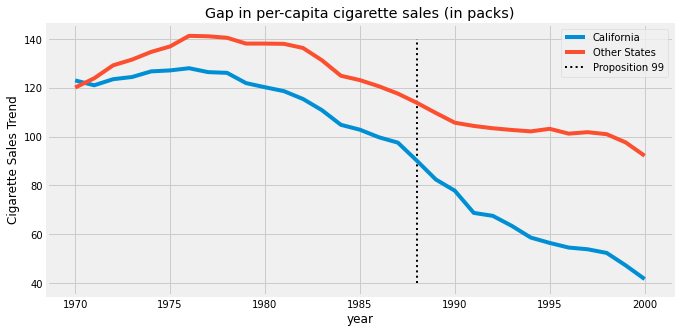

In [5]:
ax = plt.subplot(1, 1, 1)

(cigar
 .assign(california = np.where(cigar["california"], "California", "Other States"))
 .groupby(["year", "california"])
 ["cigsale"]
 .mean()
 .reset_index()
 .pivot("year", "california", "cigsale")
 .plot(ax=ax, figsize=(10,5)))

plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Cigarette Sales Trend")
plt.title("Gap in per-capita cigarette sales (in packs)")
plt.legend();  

## Prepare Data

In [6]:
# Get pre-intervention data & create a table (make one column per state and one row per year)
features = ["cigsale", "retprice"]

inverted = (cigar.query("~after_treatment") # filter pre-intervention period
            .pivot(index='state', columns="year")[features] # make one column per year and one row per state
            .T) # flip the table to have one column per state

inverted.head()

state                 1           2           3   ...          37          38  \
        year                                      ...                           
cigsale 1970   89.800003  100.300003  123.000000  ...  114.500000  106.400001   
        1971   95.400002  104.099998  121.000000  ...  111.500000  105.400001   
        1972  101.099998  103.900002  123.500000  ...  117.500000  108.800003   
        1973  102.900002  108.000000  124.400001  ...  116.599999  109.500000   
        1974  108.199997  109.699997  126.699997  ...  119.900001  111.800003   

state                 39  
        year              
cigsale 1970  132.199997  
        1971  131.699997  
        1972  140.000000  
        1973  141.199997  
        1974  145.800003  

[5 rows x 39 columns]

In [7]:
# define our Y variable as the state of California and the X as the other states.
y = inverted[3].values # state of california
X = inverted.drop(columns=3).values  # other states

In [8]:
# check table dimensions
print(inverted.shape, y.shape, X.shape)

(38, 39) (38,) (38, 38)


## Loss Function

In [9]:
# loss function.
# functools.partial - Return a new partial object which when called will behave like func called with the positional arguments args and keyword arguments keywords.
from typing import List
from operator import add
from toolz import reduce, partial


def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

## Synthetic Weights

In [10]:
# THE MAIN SYNTHETIC CONTROL FUNCTION - GET WEIGHTS
# set optimization bounds to be between 0 and 1
# scipy.optimize.fmin_slsqp - Minimize a function using Sequential Least Squares Programming
# Constraints:
# f_eqcons - Returns a 1-D array in which each element must equal 0.0 in a successfully optimized problem.
# bounds - A list of tuples specifying the lower and upper bound for each independent variable [(xl0, xu0),(xl1, xu1),…] Infinite values will be interpreted as large floating values.
from scipy.optimize import fmin_slsqp

def get_w(X, y):
    
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights

## Get Synthetic California Weights & Cigarette Sales

In [11]:
# get the weights that define the synthetic control
CA_weights = get_w(X, y)
print("Sum:", CA_weights.sum())
np.round(CA_weights, 4)

Sum: 1.0000000000001288


array([0.    , 0.    , 0.    , 0.0852, 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.113 , 0.1051, 0.4566, 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.2401, 0.    , 0.    , 0.    , 0.    , 0.    ])

In [12]:
# get synthetic california cigarette sales
CA_synth = cigar.query("~california").pivot(index='year', columns="state")["cigsale"].values.dot(CA_weights)
print(CA_synth)

[116.37738086 119.29341335 125.46488163 124.01126517 125.00610866
 126.12812194 128.4041647  126.33354829 125.65842479 122.57699531
 121.02481026 120.79008432 115.81667702 112.72157966 104.13403042
 103.31383472 101.67828383 100.31140357  92.60414381  89.97954326
  84.47435543  80.41630981  80.45152514  79.60028843  79.11292837
  77.89062047  77.22867226  77.4982622   75.00565126  73.83549179
  66.43015823]


## Plot

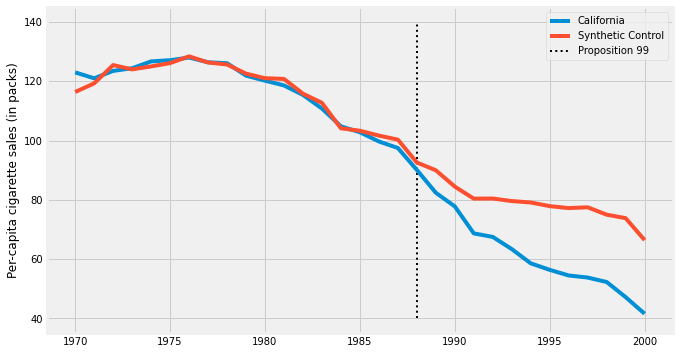

In [14]:
# plot synthetic controls
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"], label="California")
plt.plot(cigar.query("california")["year"], CA_synth, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Per-capita cigarette sales (in packs)")
plt.legend();

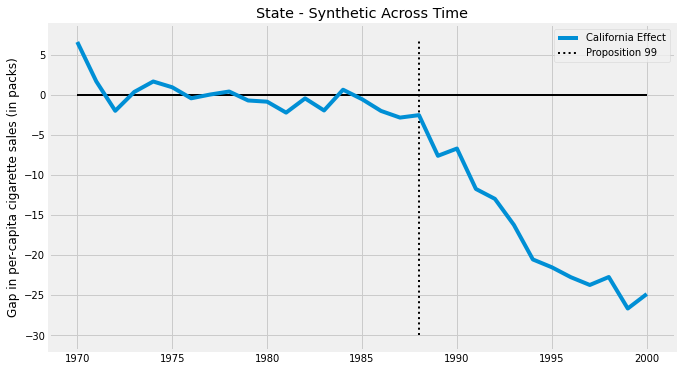

In [16]:
# estimate the treatment effect as the gap between treated and the synthetic control outcomes
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - CA_synth,
         label="California Effect")
plt.vlines(x=1988, ymin=-30, ymax=7, linestyle=":", lw=2, label="Proposition 99")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=2)
plt.title("State - Synthetic Across Time")
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.legend();